In [1]:
import pandas as pd 

import psana as ps
import numpy as np
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as npply
import sys
import os
import h5py
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter as gf
from sklearn.utils import resample
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/TestCode/EarlyScience/AnalyzeH5/')
from chemRIXSAnalysis import *
from ChemRIXSClasses import *
from filterTools import *
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/Functions/')
from Functions import *
from Load_Scans import *
from raw_data_class import RawData as RDC
from pro_data_class import ProData as PDC


font = {'size'   : 16}
mpl.rc('font', **font)
%matplotlib widget
cmap = plt.cm.get_cmap('terrain').reversed()

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [18]:
exp = 'rixlw1019'
small_data_folder = '/reg/data/ana01/rix/%s/hdf5/smalldata/' % exp #changeme
scans = [106]
raw = h5py.File(small_data_folder+'%s_Run%04d.h5' % (exp,scans[0]))
# events = np.array(raw['timestamp'])
print(list(raw.keys()))

['Sums', 'UserDataCfg', 'andor_dir', 'atmopal', 'ebeam', 'epicsAll', 'gmd', 'hsd', 'lightStatus', 'manta', 'mono_encoder', 'rix_fim0', 'rix_fim0_raw', 'rix_fim1', 'rix_fim1_raw', 'rix_fim2', 'rix_fim2_raw', 'scan', 'timestamp', 'timing', 'tt', 'xgmd']


In [6]:
raw_datas = []
for scan in scans:
    raw_data = load_scans(small_data_folder,exp,scan)
    
    
    I0_intensities_fim0, I0_specs_fim0, baselines_fim0 = \
    process_fim(raw_data.fim0_raw,np.arange(0,8),np.arange(0,50),np.arange(80,220))
    
    I0_intensities_fim1, I0_specs_fim1, baselines_fim1 = \
    process_fim(raw_data.fim1_raw,np.arange(0,8),np.arange(0,50),np.arange(80,220))
    
    intensities_fim2=process_fim_2(raw_data.fim2_raw,np.arange(0,8))
    
    andor_dir_intensities, andor_dir_specs, baseline_andor_dir = \
    process_andor(raw_data.andor_dir_raw,np.arange(500,800),np.arange(900,1300))
    
    raw_data.changeValue(I0_intensities_fim0=I0_intensities_fim0,
                        I0_specs_fim0=I0_specs_fim0,
                        baselines_fim0=baselines_fim0,
                        I0_intensities_fim1=I0_intensities_fim1,
                        I0_specs_fim1=I0_specs_fim1,
                             baselines_fim1=baselines_fim1,
                        intensities_fim2=intensities_fim2,
                        andor_dir_intensities=andor_dir_intensities,
                        andor_dir_specs=andor_dir_specs,
                        baseline_andor_dir=baseline_andor_dir)
    
    
    raw_datas = raw_datas + [raw_data]

loading TT
loading fim0
loading fim1
loading andor
loading fim2


In [4]:
bins, andor_binned_means, andor_binned_shots = energy_binning(raw_datas[0].tt_posps,y_value,n_bins)


NameError: name 'x_value' is not defined

(31447,)

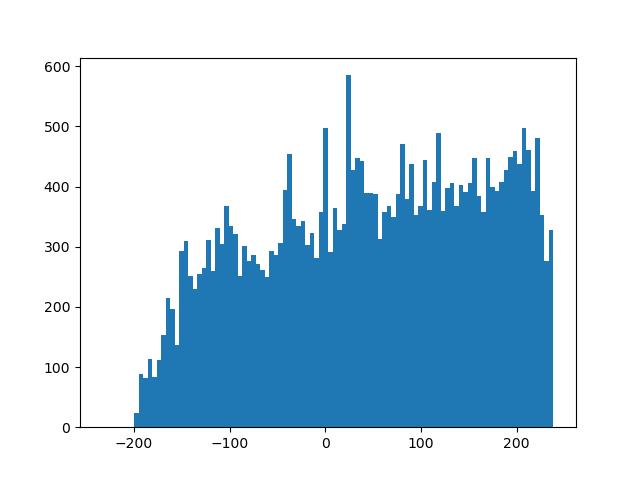

In [34]:
# raw_datas[0].getKeys()
lxt = raw_datas[0].lxt
nan_cond_1 = np.logical_not(np.isnan(raw_datas[0].lxt))
nan_cond_2 = np.logical_not(np.isnan(raw_datas[0].tt_posps))
nan_cond = nan_cond_2 & nan_cond_1
lxt = lxt[nan_cond]
tt_ps = raw_datas[0].tt_posps[nan_cond]
tt_ps.shape[0]/nan_cond.shape[0]

plt.figure()
_, bins, _ = plt.hist(tt_ps, 100)

test = lxt-tt_ps
test.shape

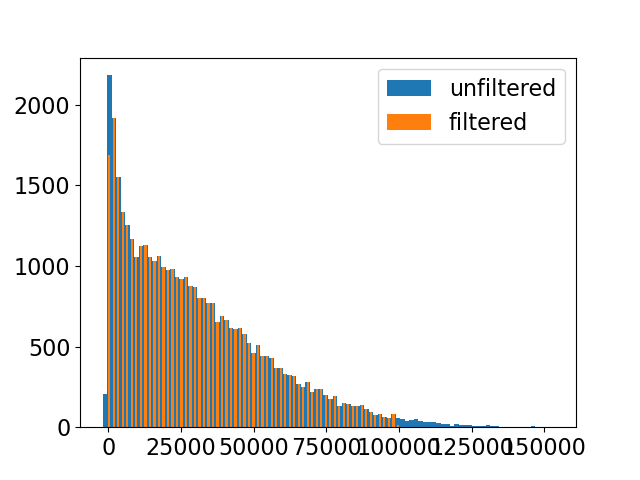

/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/Functions/Functions.py:126: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if plot_on:


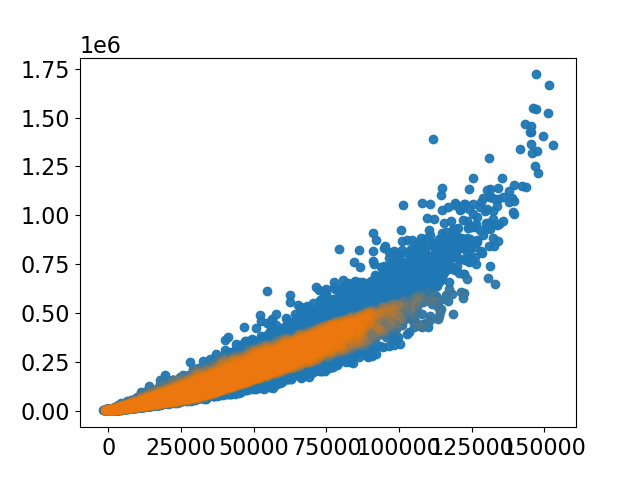

In [56]:
filter_params = []
for raw in raw_datas:
    filter_param = PDC()
    
    B_condition_1 = bounds_filter(raw.I0_intensities_fim0[5,:],[[100,100000],[3]],True) 

    # raw.I0_intensities_fim0[4,:] is I0 intensities from fim0 channel 4


    bounds_condition = B_condition_1

    L_condition_1 = lin_filter(raw.I0_intensities_fim0[5,:], raw.andor_dir_intensities,[0.05,True],True)


    linearity_condition = L_condition_1
    condition = bounds_condition & linearity_condition
    
    filter_param.changeValue(condition=condition)
    filter_params = filter_params + [filter_param]

In [57]:
scan_type = 'mono'
# scan_type = 'time'
condition = True
pro_datas = []
for i in range(0,len(raw_datas)):
    pro_data = PDC()
    pumped = raw_datas[i].laser==1
    unpumped = raw_datas[i].laser==0
    condition = filter_params[i].condition
    
    norm_by = raw_datas[i].I0_intensities_fim0[5,:]
    
    if scan_type is 'mono':

        n_bins = 100
        mono_encoder_ev = np.squeeze(mono_calib(raw_datas[i].energy_raw,raw_datas[i].mono_encoder))
        
        x_vals = mono_encoder_ev
        y_vals = raw_datas[i].andor_dir_intensities
        
        ##### pumped #####
        energy,intensity_raw_pumped = \
        mono_spectrum(x_vals[pumped],n_bins,y_vals[pumped])
        
        energy,intensity_filtered_pumped = \
        mono_spectrum(x_vals[condition&pumped],n_bins,y_vals[condition&pumped])
        
        energy,intensity_norm_filtered_pumped = \
        mono_spectrum(x_vals[condition&pumped],n_bins,y_vals[condition&pumped]/norm_by[condition&pumped])
        
        ##### unpumped #####
        energy,intensity_raw_unpumped = \
        mono_spectrum(x_vals[unpumped],n_bins,y_vals[unpumped])
        
        energy,intensity_filtered_unpumped = \
        mono_spectrum(x_vals[condition&unpumped],n_bins,y_vals[condition&unpumped])
        
        energy,intensity_norm_filtered_unpumped = \
        mono_spectrum(x_vals[condition&unpumped],n_bins,y_vals[condition&unpumped]/norm_by[condition&unpumped])

        
        pro_data.changeValue(energy=energy,
                             intensity_raw_pumped = intensity_raw_pumped,
                             intensity_filtered_pumped = intensity_filtered_pumped,
                             intensity_norm_filtered_pumped = intensity_norm_filtered_pumped,
                             intensity_raw_unpumped = intensity_raw_unpumped,
                             intensity_filtered_unpumped = intensity_filtered_unpumped,
                             intensity_norm_filtered_unpumped = intensity_norm_filtered_unpumped)
        
        pro_datas = pro_datas + [pro_data]
        
    if scan_type is 'time':
        
        x_vals = raw_datas[i].lxt
        
        y_vals = raw_datas[i].andor_dir_intensities
        
        #pumped
        d_bins_raw, andor_intensities_time_raw = time_scan(x_vals,y_vals)
        
        d_bins_filt, andor_intensities_time_filt = time_scan(x_vals[condition],y_vals[condition])
        
        andor_intensities_time_norm_filt = \
        time_scan(x_vals[condition&unpumped],y_vals[condition&unpumped]/norm_by[condition&unpumped])[1]
        
        #unpumped
        andor_intensities_time_raw_pumped = time_scan(x_vals[pumped],y_vals[pumped])[1]
        
        andor_intensities_time_filt_pumped = time_scan(x_vals[condition&pumped],y_vals[condition&pumped])[1]
        
        andor_intensities_time_norm_filt_pumped = \
        time_scan(x_vals[condition&pumped],y_vals[condition&pumped]/norm_by[condition&pumped])[1]
        
        pro_data.changeValue(d_bins_raw=d_bins_raw,
                             andor_intensities_time_raw=andor_intensities_time_raw,
                             andor_intensities_time_filt=andor_intensities_time_filt,
                             d_bins_filt=d_bins_filt,
                             andor_intensities_time_norm_filt = andor_intensities_time_norm_filt,
                             andor_intensities_time_raw_pumped = andor_intensities_time_raw_pumped,
                             andor_intensities_time_filt_pumped = andor_intensities_time_filt_pumped,
                             andor_intensities_time_norm_filt_pumped =andor_intensities_time_norm_filt_pumped
                            )
        
        pro_datas = pro_datas + [pro_data]
        

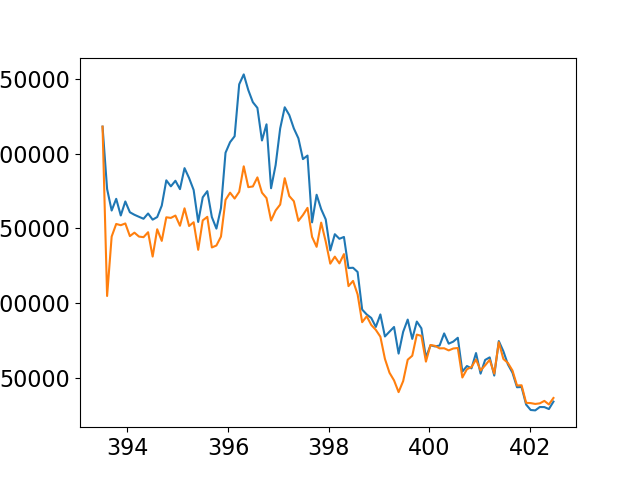

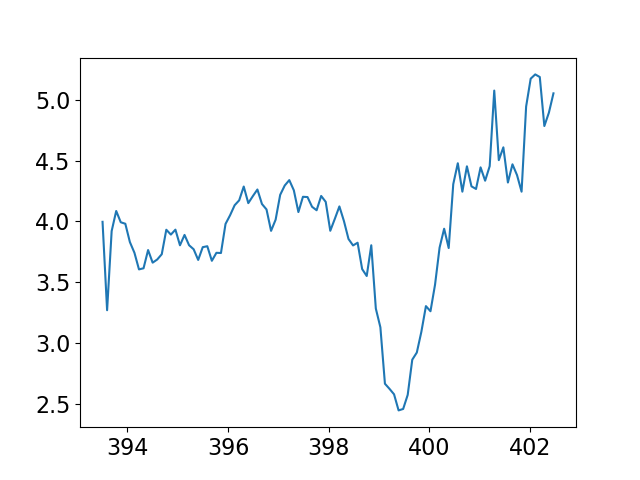

In [58]:
# plt.figure()
# plt.plot(pro_datas[0].d_bins_filt,pro_datas[0].andor_intensities_time_norm_filt_pumped)
# plt.plot(pro_datas[0].d_bins_raw,pro_datas[0].andor_intensities_time_raw)
plt.figure()
plt.plot(energy,pro_datas[0].intensity_raw_pumped)
plt.plot(energy,pro_datas[0].intensity_filtered_pumped)

plt.figure()
plt.plot(energy,pro_datas[0].intensity_norm_filtered_pumped)

In [18]:
filter_params = filter_param(raw_datas,1,6,B_lowerBond = 4000,B_upperBond = 100000,L_condition = 0.05)
pro_datas = process_data (raw_datas,filter_params,'time',scan_detector=7,norm_detector=4)


TypeError: 'ProData' object is not callable

In [19]:
pro_datas[0].getKeys()

plt.plot(pro_datas[0].d_bins_raw,pro_datas[0].andor_intensities_time_raw_pumped)
plt.plot(pro_datas[0].d_bins_raw,pro_datas[0].and)

SyntaxError: invalid syntax (2971501832.py, line 4)